In [2]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor

df = pd.read_csv('result/data/melting_point_features.csv')

y = df['Tm']
X = df.drop(columns=['Tm'])

X = X.select_dtypes(include=[np.number])
X.replace([np.inf, -np.inf], np.nan, inplace=True)

imputer = SimpleImputer(strategy='median')
X_clean = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.2, random_state=42)

base_model = LGBMRegressor(random_state=42, n_jobs=1)

Ranking features (Fast Mode)...
Ranking done in 20.8s

Starting MAE Loop (22 steps)...
   -> Top 937 features: MAE = 114.18
   -> Top 887 features: MAE = 114.66
   -> Top 837 features: MAE = 114.68
   -> Top 787 features: MAE = 114.40
   -> Top 737 features: MAE = 114.77
   -> Top 687 features: MAE = 114.73
   -> Top 637 features: MAE = 114.89
   -> Top 587 features: MAE = 114.56
   -> Top 537 features: MAE = 114.38
   -> Top 487 features: MAE = 114.96
   -> Top 437 features: MAE = 115.06
   -> Top 387 features: MAE = 115.20
   -> Top 337 features: MAE = 115.48
   -> Top  90 features: MAE = 118.69
   -> Top  80 features: MAE = 118.24
   -> Top  70 features: MAE = 119.26
   -> Top  60 features: MAE = 119.06
   -> Top  50 features: MAE = 118.67
   -> Top  40 features: MAE = 119.19
   -> Top  30 features: MAE = 121.75
   -> Top  20 features: MAE = 130.11
   -> Top  10 features: MAE = 140.65


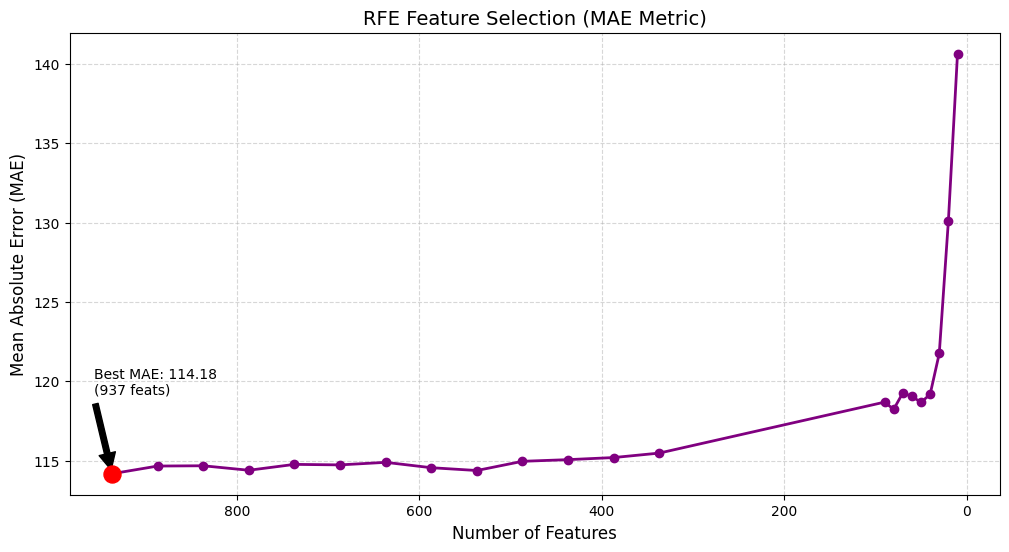


TOP 5 CONFIGURATIONS (LOWEST MAE):
   Num_Features         MAE
0           937  114.177411
1           537  114.380080
2           787  114.395915
3           587  114.556439
4           887  114.661340

LOOP PROGRESS:
    Num_Features         MAE
21            10  140.646533
20            20  130.107683
19            30  121.754719
18            40  119.185407
17            50  118.671752
16            60  119.057054
15            70  119.262915
14            80  118.238684
13            90  118.689209
12           337  115.477770


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
from sklearn.feature_selection import RFE
import time

best_params = {
    'objective': 'regression_l1',   
    'metric': 'mae',
    'learning_rate': 0.005,
    'n_estimators': 5000,
    'num_leaves': 100,
    'max_depth': 15,
    'subsample': 0.7,  
    'colsample_bytree': 0.7,
    'random_state': 2601,
    'n_jobs': 1,
    'verbose': -1
}

fast_params = {
    'objective': 'regression_l1',
    'learning_rate': 0.05,
    'n_estimators': 300,
    'num_leaves': 50,
    'n_jobs': -1,
    'verbose': -1
}

print("Ranking features (Fast Mode)...")
start_time = time.time()

rfe_selector = RFE(estimator=LGBMRegressor(**fast_params), 
                   n_features_to_select=1, 
                   step=0.1, 
                   verbose=0)

rfe_selector.fit(X_train, y_train) 

rfe_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Rank': rfe_selector.ranking_
}).sort_values(by='Rank', ascending=True)

sorted_feats = rfe_df['Feature'].tolist()
print(f"Ranking done in {time.time() - start_time:.1f}s")
max_feat = len(sorted_feats)
steps = list(range(len(sorted_feats), 300, -50)) + list(range(90, 0, -10))
results = []

print(f"\nStarting MAE Loop ({len(steps)} steps)...")

for k in steps:
    current_feats = sorted_feats[:k]
    
    model = LGBMRegressor(**best_params)
    model.fit(X_train[current_feats], y_train)
    
    y_pred = model.predict(X_test[current_feats])
    mae = mean_absolute_error(y_test, y_pred)

    print(f"   -> Top {k:3d} features: MAE = {mae:.2f}")
    results.append({'Num_Features': k, 'MAE': mae})

df_results = pd.DataFrame(results).sort_values(by='Num_Features')
df_leaderboard = df_results.sort_values(by='MAE', ascending=True).reset_index(drop=True)

csv_filename = 'result/rfe_mae_results.csv'
df_results.to_csv(csv_filename, index=False)

plt.figure(figsize=(12, 6))
plt.plot(df_results['Num_Features'], df_results['MAE'], marker='o', linewidth=2, color='purple')

best_row = df_results.loc[df_results['MAE'].idxmin()]
plt.scatter(best_row['Num_Features'], best_row['MAE'], color='red', s=150, zorder=5)
plt.annotate(f"Best MAE: {best_row['MAE']:.2f}\n({int(best_row['Num_Features'])} feats)", 
             (best_row['Num_Features'], best_row['MAE']), 
             xytext=(best_row['Num_Features']+20, best_row['MAE']+5),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.title('RFE Feature Selection (MAE Metric)', fontsize=14)
plt.xlabel('Number of Features', fontsize=12)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().invert_xaxis()
plt.show()

print("\nTOP 5 CONFIGURATIONS (LOWEST MAE):")
print(df_leaderboard.head(5))

print("\nLOOP PROGRESS:")
print(df_results.head(10))